In [13]:
import os
import requests
import datetime as dt
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import math
import statistics
from MCForecastTools import MCSimulation
import panel as pn
%matplotlib inline

In [14]:
import panel as pn
pn.extension("plotly")

In [15]:
assetList = ['^GSPC','^TNX', 'BND']
endDate = dt.datetime.now()
#endDate = '2021-01-22'
startDate = '2010-01-01'

#def getData_tdnl(assets, start, end):
assetData = pdr.DataReader(assetList, 'yahoo', startDate, endDate)
assetData = assetData['Close']
assetData.dropna(inplace=True)
    #return assetData
assetData.head(-1)

assetReturns = assetData/assetData.shift(1)

#Cleaning Data
assetReturns.dropna(inplace=True)

In [16]:
cryptoList = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'DOT-USD', 'SOL-USD', 'ADA-USD','DOGE-USD','XRP-USD']
endDate = dt.datetime.now()
#endDate = '2021-01-22'
startDate = '2010-01-01'

cryptoData = pdr.DataReader(cryptoList, 'yahoo', startDate, endDate)
cryptoData = cryptoData['Close']
cryptoData.dropna(inplace=True)

cryptoData.head(-1)


Symbols,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,
2020-08-20,"11,878.37",416.44,23.09,2.90,3.21,0.13,0.00,0.29
2020-08-21,"11,592.49",389.13,22.13,2.88,2.94,0.12,0.00,0.28
2020-08-22,"11,681.83",395.84,22.24,4.48,3.02,0.13,0.00,0.29
2020-08-23,"11,664.85",391.38,21.87,3.97,3.32,0.12,0.00,0.29
2020-08-24,"11,774.60",408.14,22.61,4.60,3.34,0.12,0.00,0.29
...,...,...,...,...,...,...,...,...
2021-12-31,"46,306.45","3,682.63",511.71,26.72,170.30,1.31,0.17,0.83
2022-01-01,"47,686.81","3,769.70",527.35,28.58,178.52,1.38,0.17,0.85
2022-01-02,"47,345.22","3,829.56",531.40,29.73,176.38,1.38,0.17,0.86


In [17]:
combined_data = pd.concat([assetData,cryptoData],axis=1,
    join="inner")
combined_data

Symbols,^GSPC,^TNX,BND,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD
Date,,,,,,,,,,,
2020-08-20,"3,385.51",0.64,88.58,"11,878.37",416.44,23.09,2.90,3.21,0.13,0.00,0.29
2020-08-21,"3,397.16",0.64,88.77,"11,592.49",389.13,22.13,2.88,2.94,0.12,0.00,0.28
2020-08-24,"3,431.28",0.65,88.67,"11,774.60",408.14,22.61,4.60,3.34,0.12,0.00,0.29
2020-08-25,"3,443.62",0.68,88.50,"11,366.13",384.00,21.48,5.52,3.26,0.11,0.00,0.28
2020-08-26,"3,478.73",0.69,88.45,"11,488.36",386.47,22.28,6.08,3.56,0.12,0.00,0.28
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,"4,793.06",1.54,84.58,"46,444.71","3,628.53",514.00,26.74,170.66,1.33,0.17,0.82
2021-12-30,"4,778.73",1.51,84.77,"47,178.12","3,713.85",518.91,27.57,172.75,1.36,0.17,0.84
2021-12-31,"4,766.18",1.51,84.75,"46,306.45","3,682.63",511.71,26.72,170.30,1.31,0.17,0.83


In [18]:
data10 = np.array([0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125])
pd.options.display.float_format = '{:,.2f}'.format
cryp_index=pd.DataFrame(columns = ('Bitcoin','Ethereum',
                                   'Binance','Polkadot',
                                   'Solana','Cardano',
                                   'Dogecoin','Ripple'))
cryp_index.loc['Random Weights'] = data10.tolist()
cryp_index

,Bitcoin,Ethereum,Binance,Polkadot,Solana,Cardano,Dogecoin,Ripple
Random Weights,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12


In [19]:
CCIX_val = ((combined_data['BTC-USD']*cryp_index['Bitcoin'].loc["Random Weights"])+
            (combined_data['ETH-USD']*cryp_index['Ethereum'].loc["Random Weights"])+
            (combined_data['BNB-USD']*cryp_index['Binance'].loc["Random Weights"])+
            (combined_data['DOT-USD']*cryp_index['Polkadot'].loc["Random Weights"])+
            (combined_data['SOL-USD']*cryp_index['Solana'].loc["Random Weights"])+
            (combined_data['ADA-USD']*cryp_index['Cardano'].loc["Random Weights"])+
            (combined_data['DOGE-USD']*cryp_index['Dogecoin'].loc["Random Weights"])+
            (combined_data['XRP-USD']*cryp_index['Ripple'].loc["Random Weights"]))

In [20]:
combined_data["CCIX"] = CCIX_val
combined_data

Symbols,^GSPC,^TNX,BND,BTC-USD,ETH-USD,BNB-USD,DOT-USD,SOL-USD,ADA-USD,DOGE-USD,XRP-USD,CCIX
Date,,,,,,,,,,,,
2020-08-20,"3,385.51",0.64,88.58,"11,878.37",416.44,23.09,2.90,3.21,0.13,0.00,0.29,"1,540.56"
2020-08-21,"3,397.16",0.64,88.77,"11,592.49",389.13,22.13,2.88,2.94,0.12,0.00,0.28,"1,501.25"
2020-08-24,"3,431.28",0.65,88.67,"11,774.60",408.14,22.61,4.60,3.34,0.12,0.00,0.29,"1,526.71"
2020-08-25,"3,443.62",0.68,88.50,"11,366.13",384.00,21.48,5.52,3.26,0.11,0.00,0.28,"1,472.60"
2020-08-26,"3,478.73",0.69,88.45,"11,488.36",386.47,22.28,6.08,3.56,0.12,0.00,0.28,"1,488.39"
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,"4,793.06",1.54,84.58,"46,444.71","3,628.53",514.00,26.74,170.66,1.33,0.17,0.82,"6,348.37"
2021-12-30,"4,778.73",1.51,84.77,"47,178.12","3,713.85",518.91,27.57,172.75,1.36,0.17,0.84,"6,451.70"
2021-12-31,"4,766.18",1.51,84.75,"46,306.45","3,682.63",511.71,26.72,170.30,1.31,0.17,0.83,"6,337.51"


In [21]:
#New Combined Data with Price/Values
new_combinedData = combined_data.drop(["BTC-USD","ETH-USD","BNB-USD","DOT-USD","SOL-USD","ADA-USD","DOGE-USD","XRP-USD"],axis=1)
new_combinedData

Symbols,^GSPC,^TNX,BND,CCIX
Date,,,,
2020-08-20,"3,385.51",0.64,88.58,"1,540.56"
2020-08-21,"3,397.16",0.64,88.77,"1,501.25"
2020-08-24,"3,431.28",0.65,88.67,"1,526.71"
2020-08-25,"3,443.62",0.68,88.50,"1,472.60"
2020-08-26,"3,478.73",0.69,88.45,"1,488.39"
...,...,...,...,...
2021-12-29,"4,793.06",1.54,84.58,"6,348.37"
2021-12-30,"4,778.73",1.51,84.77,"6,451.70"
2021-12-31,"4,766.18",1.51,84.75,"6,337.51"


In [22]:
new_combinedData_ml=pd.DataFrame(new_combinedData)
new_combinedData_ml.columns = pd.MultiIndex.from_product([['S&P500','T-Bill','Fixed Income','CCIX'],list('C')])

new_combinedData_ml.rename({'C': 'close'}, axis=1, inplace=True)
new_combinedData_ml

,S&P500,T-Bill,Fixed Income,CCIX
,close,close,close,close
Date,,,,
2020-08-20,"3,385.51",0.64,88.58,"1,540.56"
2020-08-21,"3,397.16",0.64,88.77,"1,501.25"
2020-08-24,"3,431.28",0.65,88.67,"1,526.71"
2020-08-25,"3,443.62",0.68,88.50,"1,472.60"
2020-08-26,"3,478.73",0.69,88.45,"1,488.39"
...,...,...,...,...
2021-12-29,"4,793.06",1.54,84.58,"6,348.37"
2021-12-30,"4,778.73",1.51,84.77,"6,451.70"


In [33]:
#def a financial planner function
w1 = [0.25,0.25,0.25,0.25]
years = 1
initial_investment = 10000

def new_fin_planner(data, weights,years, investment):
    
    # Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
    plan = MCSimulation(
    portfolio_data = new_combinedData_ml,
    weights = (0.593192,0.206333,0.008522,0.191953),
    num_simulation = 50,
    num_trading_days = 252*years
    )
    
    # Running a Monte Carlo simulation to forecast 30 years cumulative returns
    np.random.seed(0)
    
    plan.calc_cumulative_return()
    
    # Plot simulation outcomes
    line_plot_plan = plan.plot_simulation()  
    # Plot probability distribution and confidence intervals
    dist_plot_plan = plan.plot_distribution()
    
    # Fetch summary statistics from the Monte Carlo simulation results
    plan_summary = plan.summarize_cumulative_return()
        
    #Print summary statistics
    #print(plan_summary)
    
    # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
    ci_lower1 = plan_summary[8]*initial_investment
    ci_upper1 = plan_summary[9]*initial_investment
    
    print(f"There is a 95% chance that an initial investment of ${initial_investment:,.2f} in the portfolio"
      f" over the next {years} year(s) will end within in the range of"
      f" ${ci_lower1:,.2f} and ${ci_upper1:,.2f}")
    
    return
            

There is a 95% chance that an initial investment of $10,000.00 in the portfolio over the next 5 year(s) will end within in the range of $76,176.87 and $391,830.29


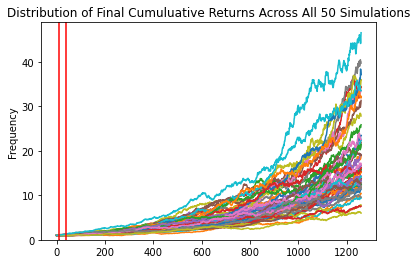

In [35]:
new_fin_planner(data=new_combinedData_ml, weights = w1, years = 5, investment = 10000)